# Hybrid CART

# Imports

In [274]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.evaluator import Evaluator

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import prince
import numpy as np

import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


Load hybrids cars

In [275]:
data = Loader.load_by_fueltype("Híbrido")
label_encoder = LabelEncoder()

d:\Archivos Uni\3 anio\Machine Learning\Proyect\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
d:\Archivos Uni\3 anio\Machine Learning\Proyect\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
d:\Archivos Uni\3 anio\Machine Learning\Proyect\Cars_Price_Prediction\Trees\..\utils\loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method

In [276]:
data["price_categ"].value_counts()

price_categ
Middle low range     6780
Middle range         3700
Middle high range    2364
Premiun              2137
Luxury               1829
High end             1766
Budget               1367
Low end               147
Very low end            9
Name: count, dtype: int64

In [277]:
data['price_categ'] = data['price_categ'].replace({ # Combinar clases similares
    'Luxury': 'Alto',
    'Premiun': 'Alto',
    'High end': 'Alto',
    'Middle high range': 'Alto',
})

data = data[data['price_categ'] != 'Very low end'] # Eliminar la clase 'Very low end'
data['price_categ'] = data['price_categ'].str.strip()

# Revisa la nueva distribución
data['price_categ'].value_counts()

C:\Users\gipas\AppData\Local\Temp\ipykernel_12956\787252135.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data['price_categ'] = data['price_categ'].replace({ # Combinar clases similares


price_categ
Alto                8096
Middle low range    6780
Middle range        3700
Budget              1367
Low end              147
Name: count, dtype: int64

In [278]:
# Ajustar y transformar la columna price_categ
data['price_categ'] = label_encoder.fit_transform(data['price_categ'])
data['price_categ'].value_counts()

price_categ
0    8096
3    6780
4    3700
1    1367
2     147
Name: count, dtype: int64

This result is telling us that in the wolrd of hybrid cars is much common to have a high price car than a low end hybrid car. So as we can see that our dataset is not perfectly balanced so we are going to studie and transfor this data to make it more tratable for the cart tree 

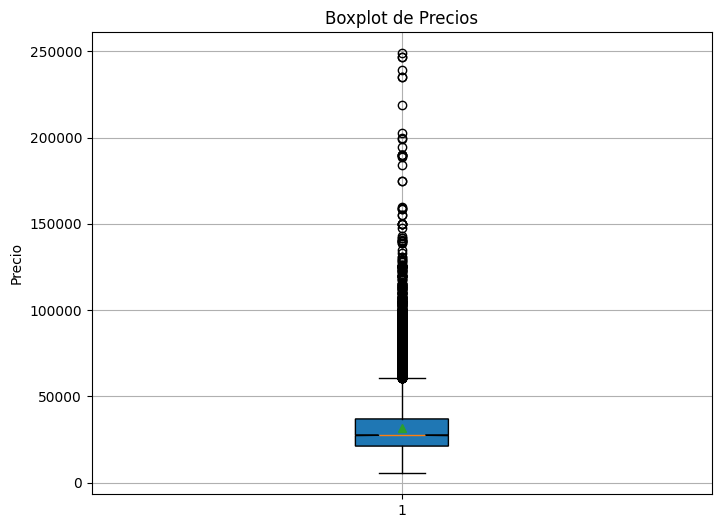

In [279]:
precios_hibridos = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_hibridos, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

The outliers were checked manually throught the data source, and we could confirmed that they are not outliers

In [280]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)  # Esta es la mediana
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)

60600.0


,price,brand
idx,,
1412,248900,LAND-ROVER
130244,246743,LAND-ROVER
129813,246743,LAND-ROVER
12846,239000,LAND-ROVER
53326,234900,LAND-ROVER
...,...,...
123654,60900,VOLVO
37177,60900,VOLVO
135706,60800,MERCEDES-BENZ


PCA and correlation matrix

In [281]:
def fill_hybrid_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    #fill the elemental columns that has a minor amount of missing data with the mode
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.length")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.height")

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")

    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_hybrid_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])
    numerical_columns.drop(columns=[ "car_id"], inplace=True)

    #if all the values of the numerical columns is 0, we remove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)

    #Remove the column with all NAs
    max_nans = 6586
    thresh = numerical_columns.shape[0] - max_nans

    numerical_columns.dropna(axis=1, thresh=thresh+1, inplace=True)
    return fill_hybrid_numerical_columns(numerical_columns)





In [282]:
numerical_columns = get_hybrid_numerical_columns(data)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.1914943513541185%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 13.023169389717273%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 7.810033917269718%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 7.152370408002295%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 6.843704148981194%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 20.641240227524193%


In [283]:
correlation_matrix = numerical_columns.corr()["price"]
print(correlation_matrix)

price                    1.000000
km                      -0.158428
year                     0.313300
cubicCapacity            0.577062
doors                    0.041924
seatingCapacity          0.234733
trunkCapacityInLiters    0.431445
maxSpeed                 0.580134
acceleration            -0.605894
power_cv                 0.756218
power_kw                 0.756342
max_torque_nm            0.762912
speakers                 0.369830
dimensions.width         0.645665
dimensions.height        0.344087
dimensions.length        0.606929
Numero_Testigos          0.096637
displacement_liters      0.575860
displacement_cc         -0.318150
number_of_cylinders      0.562844
compression_ratio       -0.249124
Llantas_Diametro_cm      0.626694
price_categ             -0.537680
Name: price, dtype: float64


In [284]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

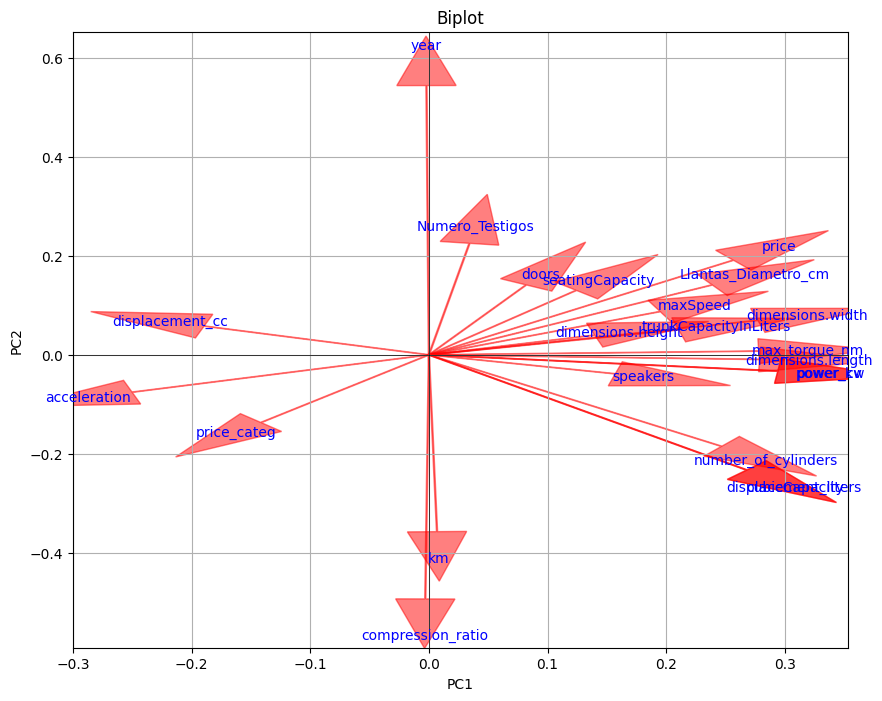

In [285]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

## CART Tree with only numerical coulumns

### First try (tree classifier)

In [286]:
X = numerical_columns.drop(columns=["price_categ","price"]) # + price_categ
y = numerical_columns["price_categ"]

In [287]:
# Train-Test Split Before Applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [288]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [289]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [290]:
y_pred = clf.predict(X_test)

# Cell 7: Evaluate the Model
# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      1625
           1       0.83      0.89      0.86       260
           2       0.63      0.71      0.67        24
           3       0.91      0.90      0.91      1353
           4       0.76      0.78      0.77       756

    accuracy                           0.89      4018
   macro avg       0.82      0.84      0.83      4018
weighted avg       0.89      0.89      0.89      4018

Confusion Matrix:
 [[1529    4    0    5   87]
 [   0  232   10   16    2]
 [   0    6   17    1    0]
 [   4   36    0 1217   96]
 [  72    0    0   96  588]]


### Second try ( Tree regressor)

In [291]:
X = numerical_columns.drop(columns="price")
y = numerical_columns["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

MAE: 1767.2444602402077 
 MSE: 14129082.8979529 
 RMSE: 3758.867236010458 
 R2: 0.9535545476140599 
 MAPE: 4.99041993002288
Mean: 1767.2444602402077
Variance: 11005929.915703196
Standard Deviation: 3317.518638335465


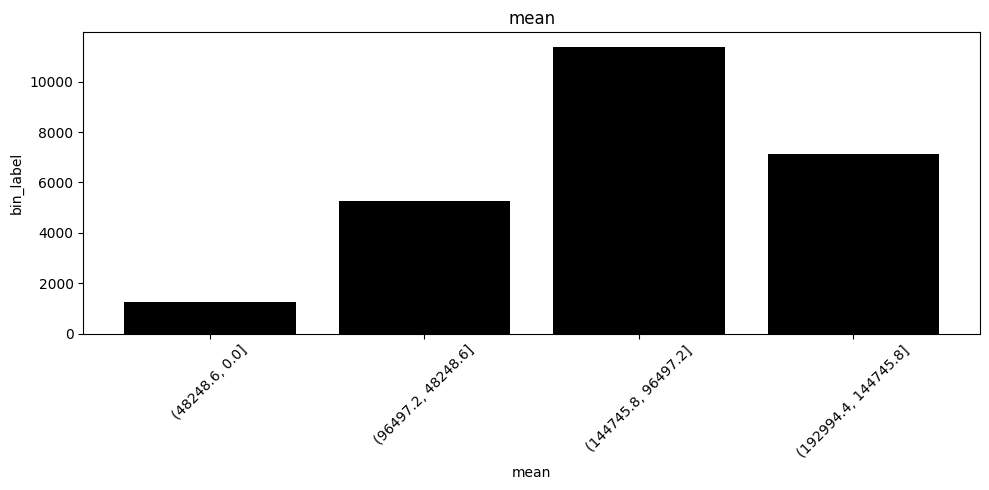

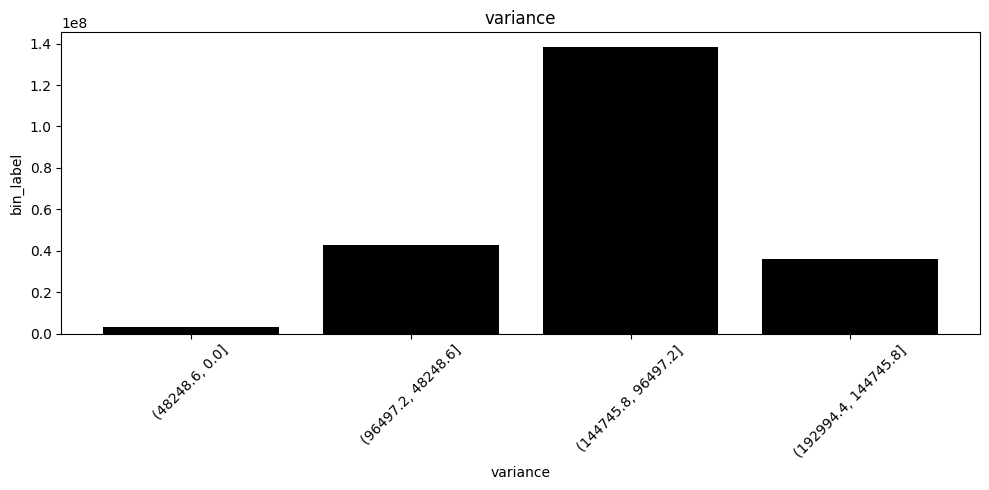

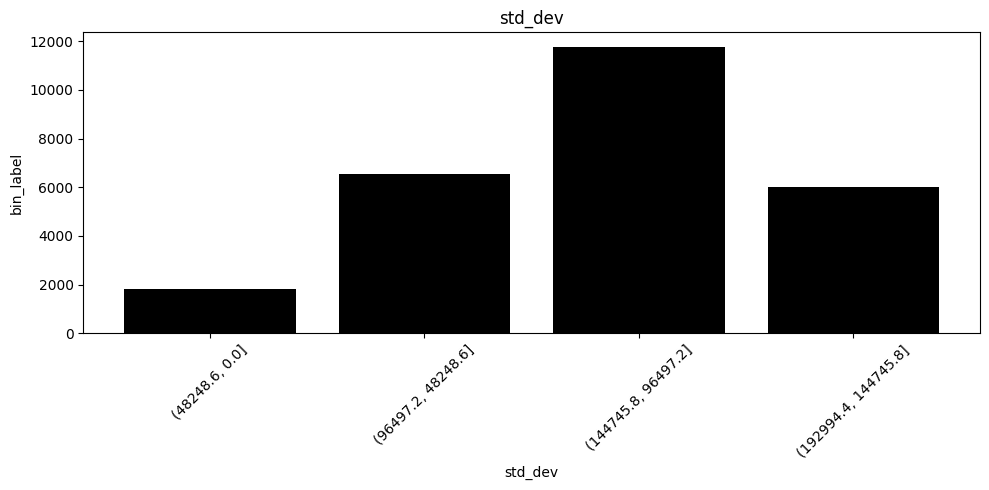

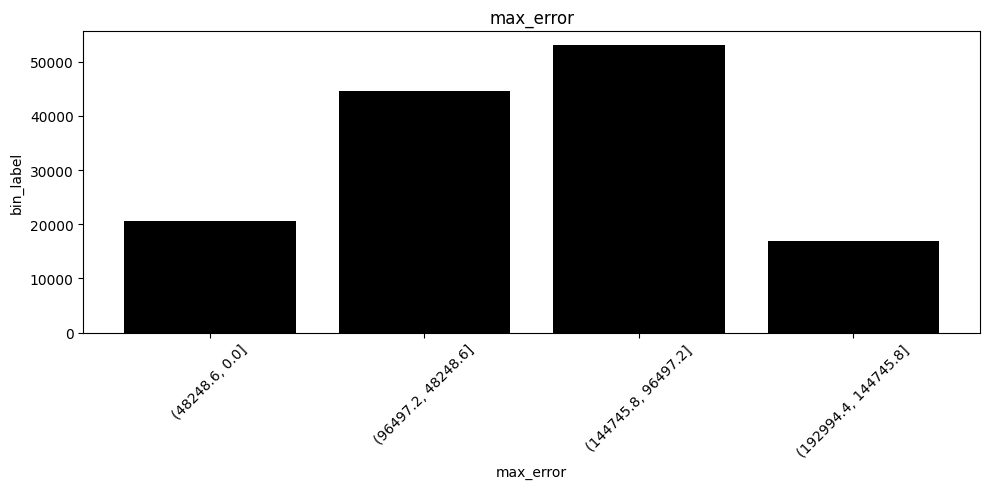

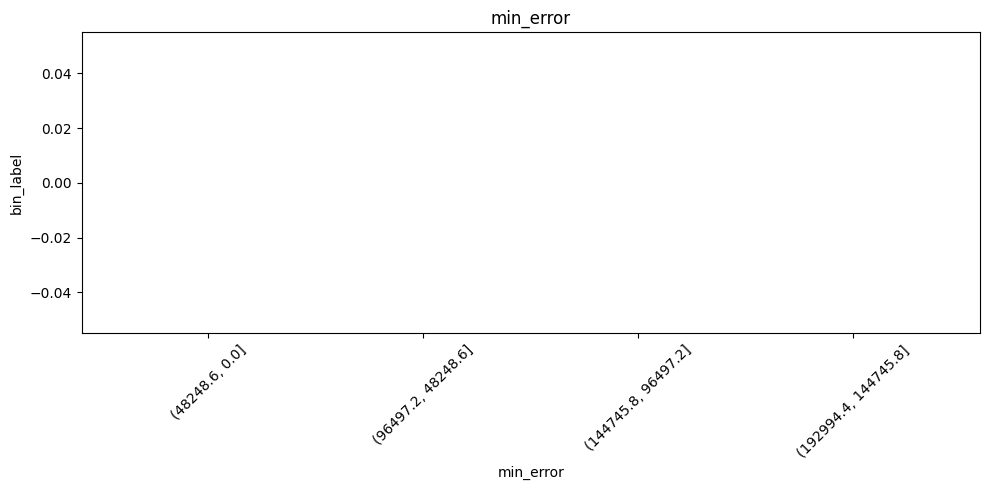

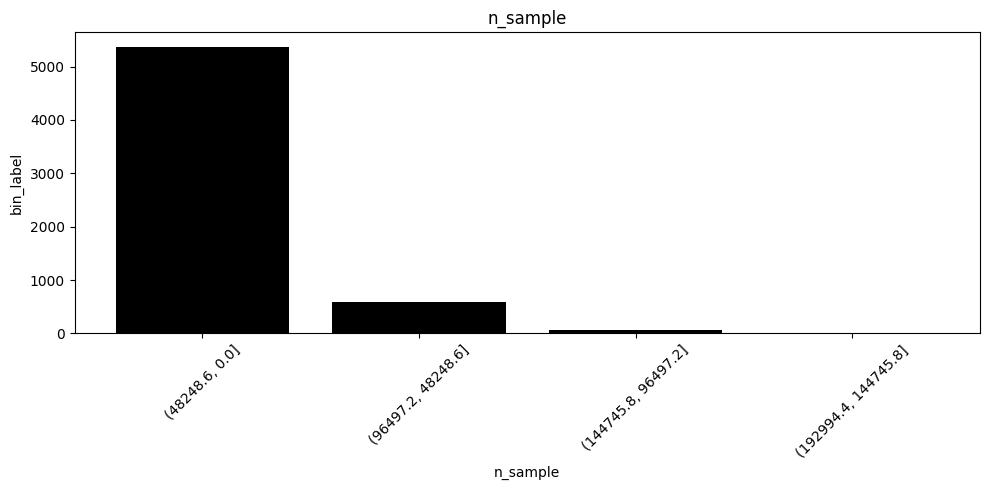

,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(48248.6, 0.0]",1266.909734,3.282057e+06,1811.644922,20509.0,0.0,5374
1,"(96497.2, 48248.6]",5250.744778,4.264076e+07,6529.989137,44600.0,0.0,584
2,"(144745.8, 96497.2]",11391.241667,1.385362e+08,11770.141881,53000.0,0.0,60
3,"(192994.4, 144745.8]",7141.666667,3.608201e+07,6006.830603,16900.0,0.0,6


In [292]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Realizar predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)

Evaluator.eval_regression(y_pred, y_test)

# CA

In [293]:
def get_hybrid_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Select and print only the categorical columns
    data['price_categ'] = data['price_categ'].astype('category')

    ret = df.select_dtypes(include=['category'])
    
    # Temporarily convert the column to strings to perform the replacement
    ret['traction'] = ret['traction'].astype(str).replace({"trasera": "trasero", "delantera": "delantero"})
    # Convert back to a categorical type
    ret['traction'] = ret['traction'].astype('category')

    
    # Remove redundant columns if this function is defined
    ret = Data_processor.remove_redundand_columns(ret)
    return ret


def fill_hybrid_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    mode_cols = ['brakes','version','jato_classification']
    for col in mode_cols:
        df = Data_processor.fill_na_with_mode(df, col)
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model"] , Y="environmentalLabel")
    return df

def category_convert(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_convert = df.select_dtypes(include=['object']).columns
    for col in cols_to_convert:
        df[col] = df[col].astype('category')
    return df

# convert object columns to category
data = category_convert(data)

categorical_columns = get_hybrid_categorical_columns(data)

categorical_columns = fill_hybrid_categorical_columns(categorical_columns)

# Check amount of missing values
missing_values = categorical_columns.isnull().sum()
missing_values = missing_values[missing_values > 0]

print(missing_values)
categorical_columns.head()
categorical_columns.columns
#print("Columnas en categorical_columns:", categorical_columns.columns)


Series([], dtype: int64)


Index(['color', 'brand', 'model', 'version', 'bodyTypeId',
       'transmissionTypeId', 'province', 'environmentalLabel',
       'jato_classification', 'traction', 'brakes', 'front_suspension',
       'rear_suspension', 'Acabado Exterior_Alerón',
       'Acabado Exterior_Cristales', 'Acabado Exterior_Faldones',
       'Acabado Exterior_Pintura', 'Acabado Exterior_Rueda', 'AC_Zones',
       'AC_Type', 'Metodo_Apertura', 'Tipo_Faro', 'interior_clock',
       'arm_suppport_front', 'arm_suppport_back', 'price_categ'],
      dtype='object')

volvemos a ponerle los nombres al price_categ porque anteriormente los habiamos transformado para el biplot  

In [294]:
# Mapeo manual de valores numéricos a nombres de categorías
manual_mapping = {
    0: "Alto",
    3: "Middle low range",
    4: "Middle range",
    1: "Budget",
    2: "Low end"
}

# Reemplazar los valores numéricos en 'price_categ' con sus nombres correspondientes
categorical_columns["price_categ"] = categorical_columns["price_categ"].map(manual_mapping)

# Obtener la distribución con los nombres de categoría
distribution = categorical_columns["price_categ"].value_counts()
print(distribution)


price_categ
Alto                8096
Middle low range    6780
Middle range        3700
Budget              1367
Low end              147
Name: count, dtype: int64


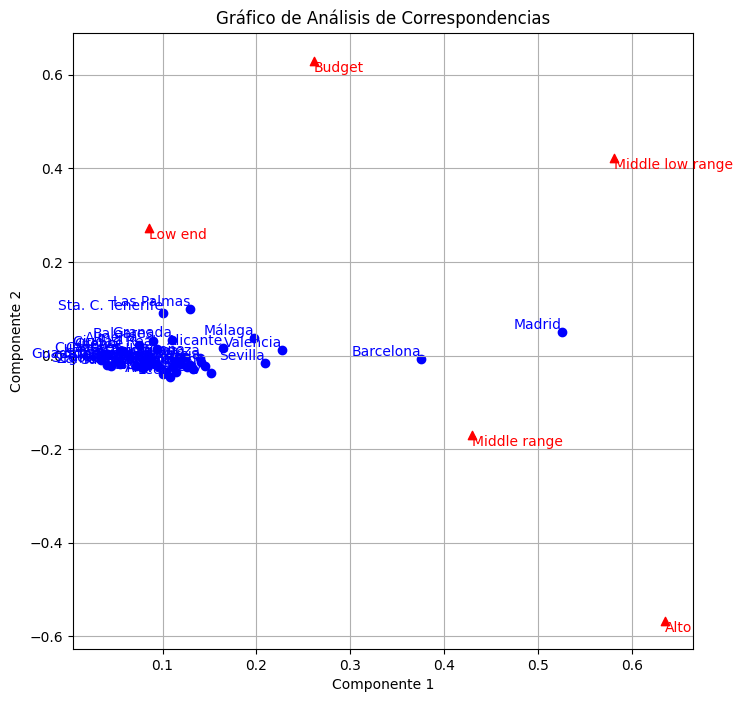

In [295]:
Data_processor.CA(categorical_columns=categorical_columns, col_x="province", col_y="price_categ")

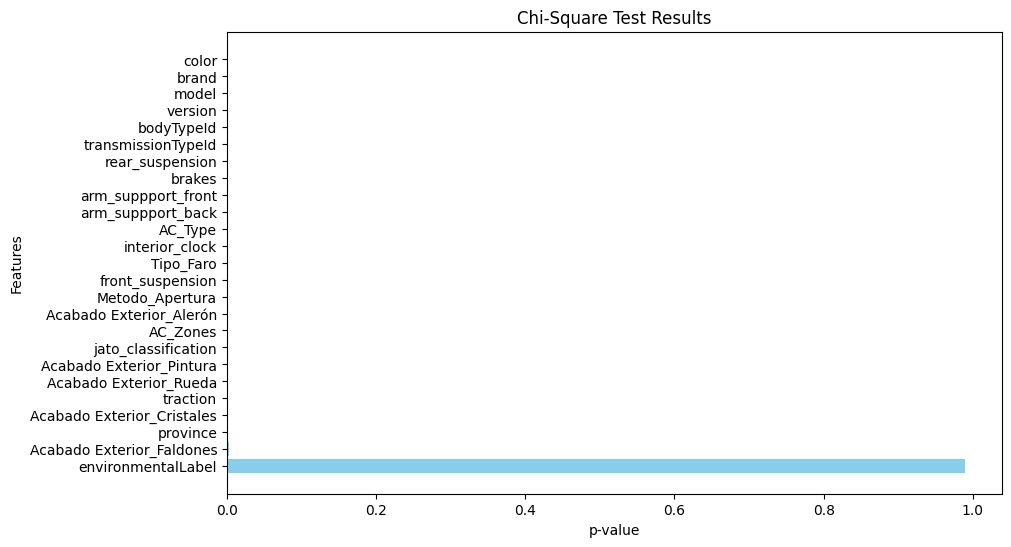

Index(['color', 'brand', 'model', 'version', 'bodyTypeId',
       'transmissionTypeId', 'rear_suspension', 'brakes', 'arm_suppport_front',
       'arm_suppport_back', 'AC_Type', 'price_categ'],
      dtype='object')

In [296]:
categorical_columns = Data_processor.chi_square_filter(categorical_columns, "price_categ", p_value_filter=0)
categorical_columns.columns

# Categorical CART

In [297]:
columns = list(categorical_columns.columns)
columns.remove("price_categ")
for col in columns:
    categorical_columns[col] = label_encoder.fit_transform(categorical_columns[col])

# Preparar los datos
X = categorical_columns.drop(columns=["price_categ"])
Y = categorical_columns["price_categ"].apply(lambda x: Loader.encode_price_categ(x))

# Dividir los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Crear el modelo de árbol de decisión
tree_model = DecisionTreeClassifier(random_state=42, criterion = "entropy")

# Entrenar el modelo
tree_model.fit(X_train, Y_train)

# Predecir las etiquetas del conjunto de prueba
Y_pred = tree_model.predict(X_test)

In [298]:
result = pd.DataFrame({"Real_Categorie": Y_test, "Prediction": Y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result.head()

,Real_Categorie,Prediction,diff
3885,Budget,Budget,0
12760,Budget,Budget,0
10509,Luxury,Luxury,0
5184,Budget,Budget,0
1737,Budget,Budget,0


In [299]:
Evaluator.eval_classfication(Y_pred, Y_test, binary_classification = False)

Accuracy: 0.8329185332669653 
 Precision: 0.833005203899287 
 Recall: 0.8329185332669653 
 F1 Score: 0.832742191965596
Confusion Matrix:
 [[  23   14    5    2    0]
 [  22  314   72    0    2]
 [   4   55 1763  173   39]
 [   2    6  238  718  146]
 [   0    1   40  186 2202]]


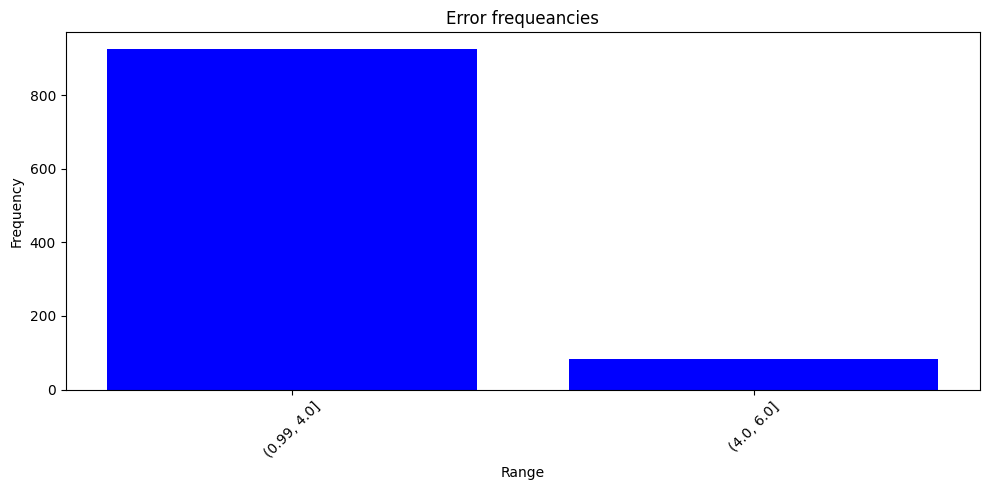

Errors: {'(0.99, 4.0]': 925, '(4.0, 6.0]': 82}
Error mean: 2.340615690168818
Error rate: 16.708146673303467 %
Overall mean: 0.39107350257176043


In [300]:
Evaluator.eval_ordinal_classification (result["diff"])

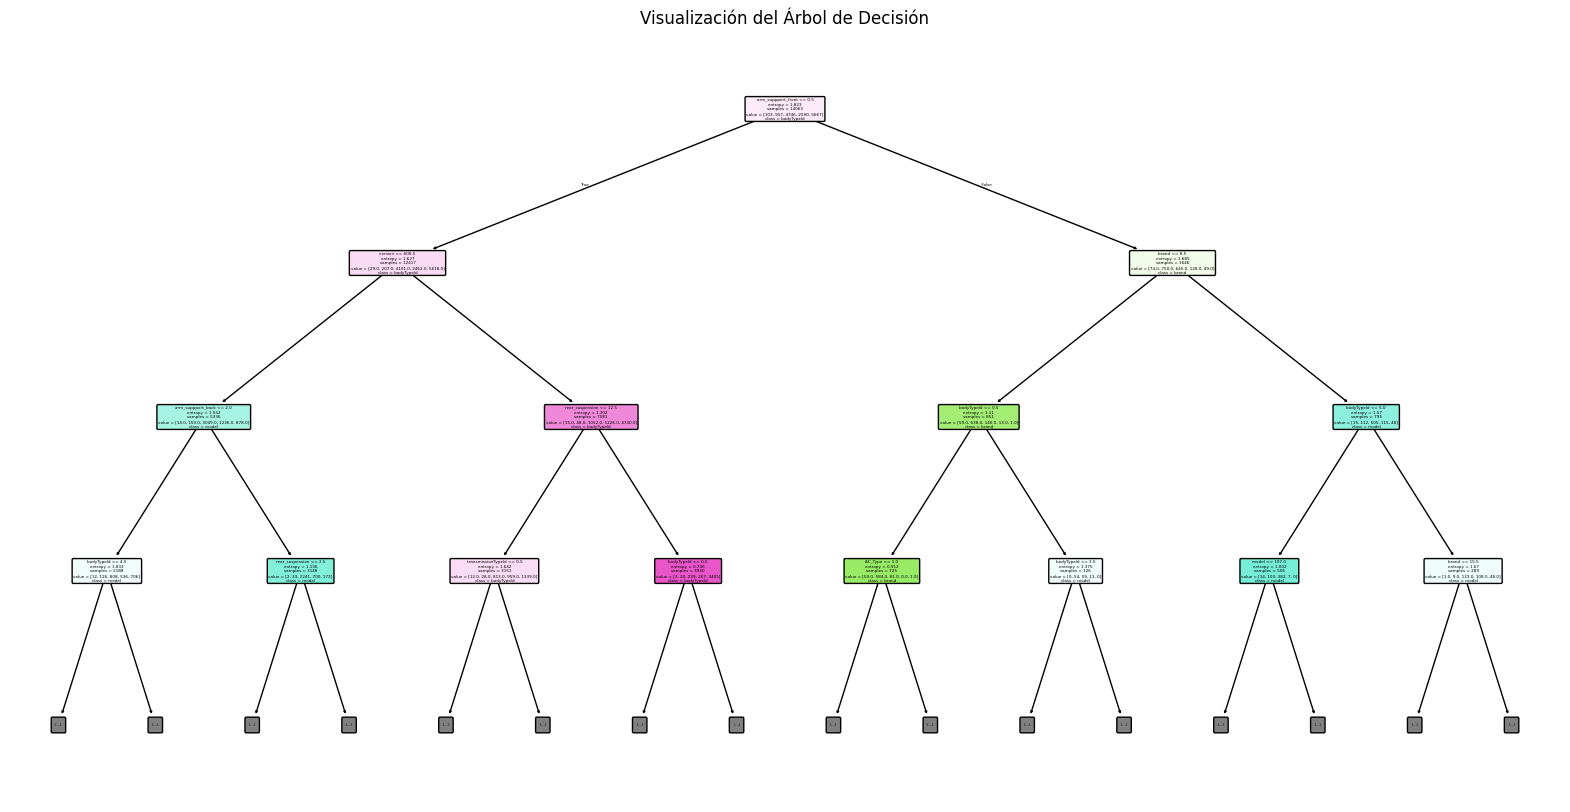

In [301]:
plt.figure(figsize=(20,10))

# Dibujar el árbol de decisión
plot_tree(tree_model, 
          filled=True, 
          rounded=True, 
          class_names=X_train.columns, 
          feature_names=X.columns, 
          max_depth=3)  # Puedes ajustar la profundidad para una mejor visualización o quitar este parámetro para mostrar todo el árbol
plt.title('Visualización del Árbol de Decisión')
plt.show()

# Random Forest

In [302]:
columns = list(categorical_columns.columns)
columns.remove("price_categ")
for col in columns:
    categorical_columns[col] = label_encoder.fit_transform(categorical_columns[col])

# Preparar los datos
X = categorical_columns.drop(columns=["price_categ"])
Y = categorical_columns["price_categ"].apply(lambda x: Loader.encode_price_categ(x))

# Dividir los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Crear el modelo de árbol de decisión
tree_model = RandomForestClassifier(random_state=42, criterion = "entropy")

# Entrenar el modelo
tree_model.fit(X_train, Y_train)

# Predecir las etiquetas del conjunto de prueba
Y_pred = tree_model.predict(X_test)

In [303]:
result = pd.DataFrame({"Real_Categorie": Y_test, "Prediction": Y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result.head()

,Real_Categorie,Prediction,diff
3885,Budget,Budget,0
12760,Budget,Budget,0
10509,Luxury,Luxury,0
5184,Budget,Budget,0
1737,Budget,Budget,0


In [304]:
Evaluator.eval_classfication(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.8433714949394392 
 Precision: 0.8414987849273144 
 Recall: 0.8433714949394392 
 F1 Score: 0.8419821118154084
Confusion Matrix:
 [[1787    2   47   35  163]
 [   7   21    1   13    2]
 [  27    0 2240    0  162]
 [  84   17    1  307    1]
 [ 206    0  173    3  728]]


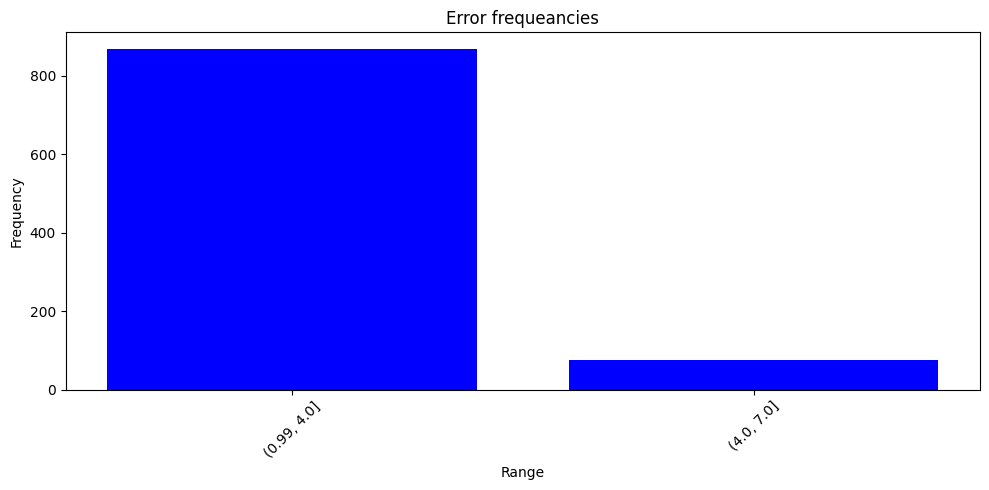

Errors: {'(0.99, 4.0]': 868, '(4.0, 7.0]': 76}
Error mean: 2.4078389830508473
Error rate: 15.662850506056081 %
Overall mean: 0.3771362203417953


In [305]:
Evaluator.eval_ordinal_classification (result["diff"])

# Naive Bayes

In [306]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
import numpy as np
import pandas as pd

# Prepare the data
X = categorical_columns.drop(columns=["price_categ"])
Y = categorical_columns["price_categ"].apply(lambda x: Loader.encode_price_categ(x))

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Create the Naive Bayes model
nb_model = GaussianNB() # You can try other Naive Bayes models such as ComplementNB, BernoulliNB, BinomialNB but Gaussian gives the best results in this case

# Train the model
nb_model.fit(X_train, Y_train)

# Predict the labels of the test set
Y_pred = nb_model.predict(X_test)

# Create a results DataFrame to compare predictions
result = pd.DataFrame({"Real_Categorie": Y_test, "Prediction": Y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)

# Show the first few rows of the results
result.head()


,Real_Categorie,Prediction,diff
3885,Budget,Luxury,5
12760,Budget,Budget,0
10509,Luxury,Luxury,0
5184,Budget,Middle range,1
1737,Budget,Middle range,1


In [307]:
Evaluator.eval_classfication(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.5503567280570765 
 Precision: 0.582607592470543 
 Recall: 0.5503567280570765 
 F1 Score: 0.5139703045596888
Confusion Matrix:
 [[ 430    0  508  174  922]
 [   5    0   11   25    3]
 [  46    0 2184    0  199]
 [  32    0   67  300   11]
 [ 113    0  589    5  403]]


C:\Users\gipas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
